In [93]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

class PolymerMotion:
    def __init__(self, num_particles, spring_constants, mass=1.0, dt=0.01, total_time=10):
        self.num_particles = num_particles
        self.spring_constants = np.asarray(spring_constants)
        self.mass = np.full(num_particles, mass) if not isinstance(mass, np.ndarray) else mass
        self.dt = dt
        self.total_time = total_time
        self.time_steps = int(total_time / dt)

        # Initialize particle positions in 2D and zero velocities
        self.positions = np.random.rand(num_particles, 2)
        self.velocities = np.zeros((num_particles, 2))
        self.trajectory = np.zeros((self.time_steps, num_particles, 2))

    def forces(self, positions):
        """Compute spring forces between particles based on Hooke's law."""
        F = np.zeros((self.num_particles, 2))
        for i in range(self.num_particles):
            for j in range(i + 1, self.num_particles):
                displacement = positions[j] - positions[i]
                distance = np.linalg.norm(displacement)
                if distance > 0:
                    force_magnitude = self.spring_constants[i] * displacement / distance
                    F[i] += force_magnitude
                    F[j] -= force_magnitude  # Newton's third law
        return F

    def motion_equations(self, y, t):
        """ODE system: returns derivatives of position and velocity."""
        pos = y[:self.num_particles * 2].reshape((self.num_particles, 2))
        vel = y[self.num_particles * 2:].reshape((self.num_particles, 2))

        F = self.forces(pos)
        damping = -0.1 * vel  # simple linear damping

        dydt = np.zeros_like(y)
        dydt[:self.num_particles * 2] = vel.flatten()
        dydt[self.num_particles * 2:] = ((F + damping) / self.mass[:, None]).flatten()

        return dydt

    def simulate(self):
        """Run the simulation and return the trajectory."""
        y0 = np.hstack((self.positions.flatten(), self.velocities.flatten()))
        t = np.linspace(0, self.total_time, self.time_steps)
        sol = odeint(self.motion_equations, y0, t)
        self.trajectory = sol[:, :self.num_particles * 2].reshape((-1, self.num_particles, 2))
        return self.trajectory

    def generate_transition_matrix(self):
        """Construct a transition matrix based on displacement similarity between particles."""
        cumulative_displacements = np.zeros((self.num_particles, self.num_particles))

        for t in range(1, self.time_steps):
            for i in range(self.num_particles):
                for j in range(self.num_particles):
                    displacement = np.linalg.norm(self.trajectory[t, i] - self.trajectory[t - 1, j])
                    cumulative_displacements[i, j] += displacement

        # Invert cumulative displacement to get similarity (smaller displacement = higher prob)
        with np.errstate(divide='ignore'):
            transition_matrix = np.where(cumulative_displacements > 0, 1.0 / cumulative_displacements, 0.0)

        # Normalize rows to make valid transition probabilities
        row_sums = transition_matrix.sum(axis=1, keepdims=True)
        transition_matrix = np.where(row_sums > 0, transition_matrix / row_sums, 1.0 / self.num_particles)

        return transition_matrix

    def plot_trajectories(self):
        """Plot X and Y positions of particles over time."""
        time = np.linspace(0, self.total_time, self.time_steps)
        plt.figure(figsize=(12, 6))

        for i in range(self.num_particles):
            plt.plot(time, self.trajectory[:, i, 0], label=f'Particle {i+1} X', linestyle='-')
            plt.plot(time, self.trajectory[:, i, 1], label=f'Particle {i+1} Y', linestyle='--')

        plt.title('Particle Trajectories Over Time')
        plt.xlabel('Time')
        plt.ylabel('Position')
        plt.legend()
        plt.grid()
        plt.show()


def generate_correlated_random_walks(polymer_model, num_walks, num_steps, target_corr_matrix):
    """
    Generate correlated random walks using a transition matrix derived from a polymer simulation.
    :param polymer_model: Simulated PolymerMotion instance.
    :param num_walks: Number of walks to generate.
    :param num_steps: Number of steps in each walk.
    :param target_corr_matrix: Desired correlation matrix between walks.
    """
    # Check if the correlation matrix is valid
    assert np.all(np.linalg.eigvals(target_corr_matrix) > 0), "Correlation matrix must be positive definite."

    # Cholesky decomposition
    L = np.linalg.cholesky(target_corr_matrix)

    # Build transition matrix from polymer dynamics
    transition_matrix = polymer_model.generate_transition_matrix()

    # Generate independent discrete state walks using the transition probabilities
    independent_walks = np.zeros((num_walks, num_steps))
    for i in range(num_walks):
        state = np.random.choice(polymer_model.num_particles)
        walk = [state]
        for _ in range(num_steps - 1):
            state = np.random.choice(polymer_model.num_particles, p=transition_matrix[state])
            walk.append(state)
        independent_walks[i] = walk

    # Transform to correlated walks: (L @ independent_walks) should be transposed
    correlated_walks = (L @ independent_walks)  # Shape: (num_steps, num_walks)

    return correlated_walks

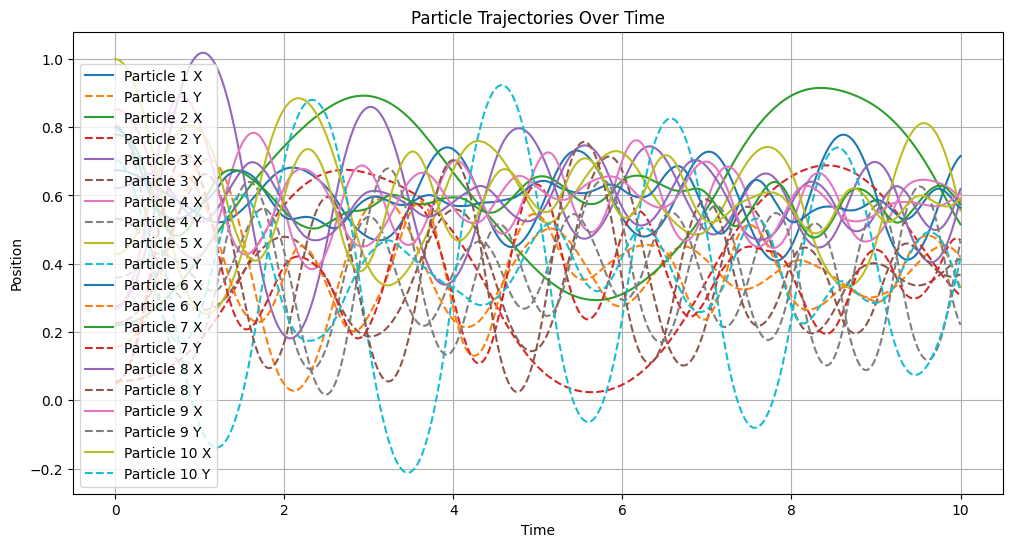

In [94]:
# Parameters
num_particles = 10
spring_constants = np.random.rand(num_particles)  # Random spring constants for each particle
polymer_model = PolymerMotion(num_particles, spring_constants)

# Simulate the polymer motion
trajectory = polymer_model.simulate()

# Plot the trajectories as a function of time
polymer_model.plot_trajectories()

In [95]:
#Generate a correlation matrix from Higham's algorithm

import numpy as np
from scipy.linalg import eigh

# Step 1: Generate a random matrix and symmetrize it
def generate_random_correlation_matrix(n):
    # Generate a random matrix
    A = np.random.rand(n, n)

    # Symmetrize the matrix
    A = (A + A.T) / 2

    # Step 2: Force diagonal elements to 1 (for correlation matrix)
    np.fill_diagonal(A, 1)

    return A

# Step 3: Apply Higham's algorithm to ensure the matrix is PSD
def higham_psd(matrix, tol=1e-8):
    """
    Adjusts the matrix to be positive semi-definite using Higham's algorithm.
    Parameters:
    - matrix: Input matrix to be corrected.
    - tol: Tolerance for eigenvalue correction.
    """
    # Eigen decomposition (guaranteed to work for symmetric matrices)
    eigvals, eigvecs = eigh(matrix)

    # Replace negative eigenvalues or those below tolerance with zeros (for PSD)
    eigvals = np.clip(eigvals, tol, None)

    # Reconstruct the matrix from modified eigenvalues and eigenvectors
    psd_matrix = eigvecs @ np.diag(eigvals) @ eigvecs.T

    # Step 4: Rescale to ensure diagonals are exactly 1
    D = np.sqrt(np.diag(psd_matrix))
    psd_matrix = psd_matrix / np.outer(D, D)

    # Fix numerical issues with diagonal exactly being 1
    np.fill_diagonal(psd_matrix, 1)
    return psd_matrix

In [109]:
# Step 5: Generate a random matrix and make it a PSD correlation matrix
n = 1000  # Number of variables
random_matrix = generate_random_correlation_matrix(n)
psd_matrix = higham_psd(random_matrix)

# Example of generating correlated random walks
target_corr_matrix = psd_matrix

In [110]:
print("target_corr_matrix shape:", np.shape(target_corr_matrix))

target_corr_matrix shape: (1000, 1000)


In [112]:
transition_matrix = polymer_model.generate_transition_matrix()
num_walks = 1000
num_steps = 5000
random_walks = generate_correlated_random_walks(polymer_model, num_walks, num_steps, target_corr_matrix)

In [113]:
#Function to rescale the walks

def rescale_to_limits(data, lower_limit, upper_limit):

    min_val = np.min(data)
    max_val = np.max(data)

    # Rescale using min-max normalization
    rescaled_data = (data - min_val) / (max_val - min_val)  # Normalize to [0, 1]
    rescaled_data = rescaled_data * (upper_limit - lower_limit) + lower_limit  # Scale to [lower_limit, upper_limit]

    return rescaled_data

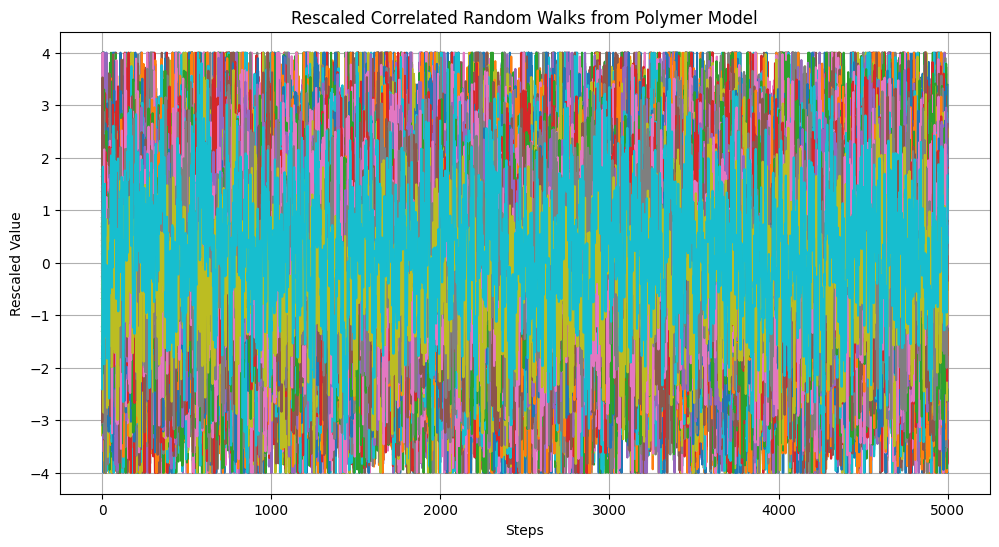

In [114]:
# Rescale each random walk to the range [lower_limit, upper_limit]
lower_limit = -4.0  # Specify the lower limit
upper_limit = 4.0  # Specify the upper limit

plt.figure(figsize=(12, 6))
r=[]

for i in range(random_walks.shape[0]):
    rescaled_walk = rescale_to_limits(random_walks[i], lower_limit, upper_limit)
    r.append(rescaled_walk)
    plt.plot(rescaled_walk, label=f'Walk {i+1}')

plt.title('Rescaled Correlated Random Walks from Polymer Model')
plt.xlabel('Steps')
plt.ylabel('Rescaled Value')
plt.grid()
plt.show()

In [115]:
#Randomly shuffle the generated random walks

r_shuffled = []

for i in range(len(r)):
    # Make a copy of r[i] to avoid modifying the original array
    temp = r[i].copy()
    np.random.shuffle(temp)
    r_shuffled.append(temp)

In [116]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Define chaotic PRNG function
def chaotic_prng(r=3.9, x0=0.5, n=10):
    if not (0 < x0 < 1):
        raise ValueError("Initial value x0 must be between 0 and 1.")
    if not (0 < r <= 4):
        raise ValueError("Control parameter r must be between 0 and 4.")

    numbers = np.empty(n)
    x = x0
    for i in range(n):
        x = r * x * (1 - x)
        numbers[i] = x

    return numbers

# Define drift and diffusion functions
def mu(x):
    return -0.5 * x  # Example drift term (mean-reverting)

def sigma(x):
    return 0.5 * np.ones_like(x)  # Example diffusion term (constant volatility)

# Dynamic_Random_Graph class definition
class Dynamic_Random_Graph:
    def __init__(self, num_nodes, coupling_constants):
        self.graph = nx.Graph()
        self.num_nodes = num_nodes

        # Ensure coupling_constants is an array of length num_nodes
        if len(coupling_constants) != num_nodes:
            raise ValueError("Length of coupling_constants must match num_nodes.")

        self.coupling_constants = coupling_constants
        self.positions = np.random.rand(num_nodes)  # Initialize node positions
        self.history_positions = []  # Store positions over time
        self.create_graph()

    def create_graph(self):
        """Initialize the graph with nodes and edges based on positions."""
        for i in range(self.num_nodes):
            self.graph.add_node(i, pos=self.positions[i])

        for i in range(self.num_nodes):
            for j in range(i + 1, self.num_nodes):
                self.add_edge_based_on_position(i, j)

    def add_edge_based_on_position(self, i, j):
        """Add an edge based on node positions (closer nodes are more likely to form edges)."""
        distance = abs(self.positions[i] - self.positions[j])
        coupling_constant_ij = (self.coupling_constants[i] + self.coupling_constants[j]) / 2
        edge_probability = np.exp(-distance * coupling_constant_ij)  # Edge probability decreases with distance
        if np.random.rand() < edge_probability:
            self.graph.add_edge(i, j)

    def update_graph_edges(self):
        """Update the edges based on new node positions."""
        self.graph.clear_edges()
        for i in range(self.num_nodes):
            for j in range(i + 1, self.num_nodes):
                self.add_edge_based_on_position(i, j)

    def simulate_sde(self, mu, sigma, dt, num_steps):
        """Simulate the stochastic differential equation (SDE) and update node positions."""
        for _ in range(1, num_steps + 1):  # Start from 1 for indexing consistency
            dW = r_shuffled[_ - 1][0:self.num_nodes] * np.sqrt(dt)  # Use _-1 for 0-indexed array
            self.positions += mu(self.positions) * dt + sigma(self.positions) * dW
            self.history_positions.append(self.positions.copy())  # Store positions for each step
            self.update_graph_edges()  # Update edges after positions change

    def get_position_history(self):
        """Return the time history of node positions as a NumPy array."""
        return np.array(self.history_positions)

In [117]:
# Initialize parameters
num_nodes = 10
coupling_constants = chaotic_prng(r=3.8, x0=0.4, n=num_nodes)  # Using chaotic PRNG for coupling constants
dt = 0.001
num_steps = 1000  # Number of time steps

# Initialize the Dynamic_Random_Graph object
dynamic_graph = Dynamic_Random_Graph(num_nodes=num_nodes, coupling_constants=coupling_constants)

# Simulate the time series using SDE
dynamic_graph.simulate_sde(mu, sigma, dt, num_steps)

# Retrieve the time history of node positions
position_history = dynamic_graph.get_position_history()

# Plotting the time series of node positions
time = np.arange(position_history.shape[0]) * dt

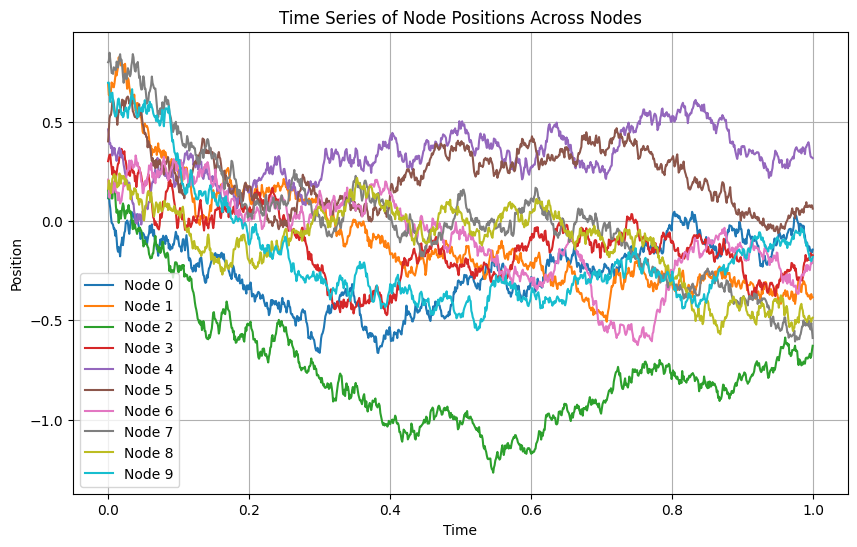

In [118]:
plt.figure(figsize=(10, 6))
for node in range(num_nodes):
    plt.plot(time, position_history[:, node], label=f'Node {node}')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Time Series of Node Positions Across Nodes')
plt.legend()
plt.grid(True)
plt.show()

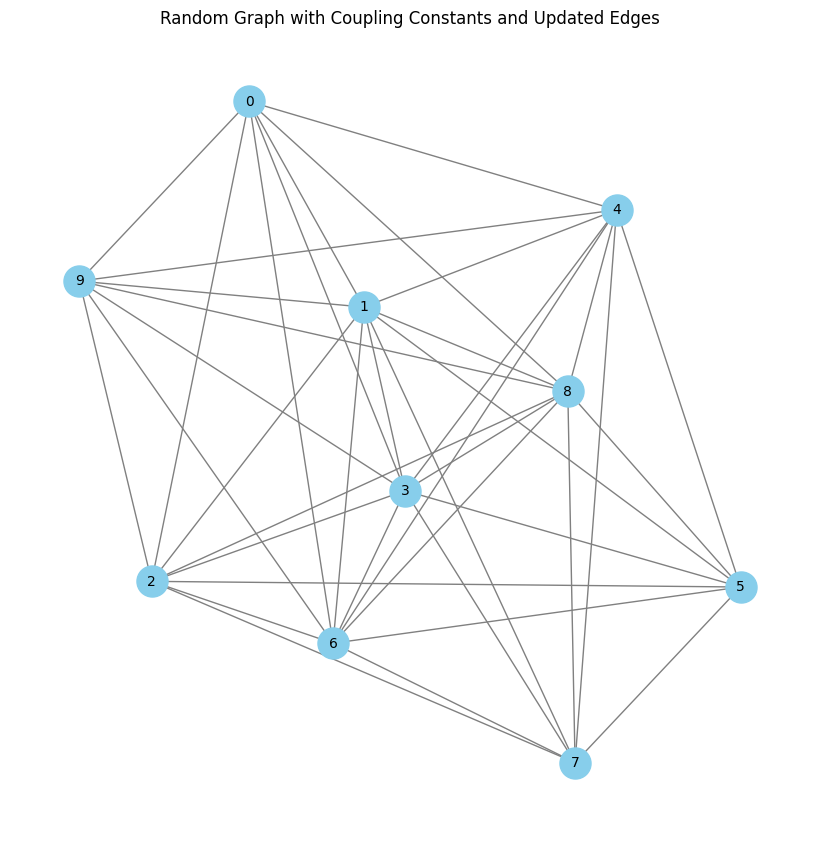

In [119]:
# Plotting the random graph
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(dynamic_graph.graph)  # Spring layout for better visualization
nx.draw(dynamic_graph.graph, pos, with_labels=True, node_color='skyblue', node_size=500, edge_color='gray', font_size=10)
plt.title('Random Graph with Coupling Constants and Updated Edges')
plt.show()

In [120]:
import numpy as np

# Function to rescale a time series to a specific range [x_min, x_max]
def rescale_time_series(time_series, x_min, x_max):
    ts_min = np.min(time_series)
    ts_max = np.max(time_series)

    # Perform min-max scaling
    rescaled_ts = (time_series - ts_min) / (ts_max - ts_min) * (x_min - x_max) + x_max
    return rescaled_ts

# Function to sample random numbers from the rescaled time series between [y_min, y_max]
def sample_from_time_series(time_series, y_min, y_max, num_samples):
    # Filter the values in the time series between y_min and y_max
    filtered_values = time_series[(time_series >= y_min) & (time_series <= y_max)]

    if len(filtered_values) == 0:
        raise ValueError(f"No values in the time series between {y_min} and {y_max}.")

    # Sample random values from the filtered time series
    sampled_values = np.random.choice(filtered_values, size=num_samples, replace=True)
    return sampled_values

In [142]:
# Example usage:
test_node=8

# Example time series data (positions of a node over time)
example_time_series =position_history[:, test_node]  # Replace with actual node positions

# Rescale the time series between [10, 50]
rescaled_ts = rescale_time_series(example_time_series, 50, 90)

# Sample 5 random values from the rescaled time series between [20, 40]
sampled_values = sample_from_time_series(rescaled_ts, 50, 90, num_samples=80)

In [143]:
print("Sampled Values:", sampled_values)

Sampled Values: [86.08330888 54.41678581 73.34806287 66.44863355 57.85925646 86.88446589
 81.6304211  76.17449462 58.08671573 71.74533468 86.69497563 67.13231765
 84.39100819 59.75383399 85.07521557 61.1582734  77.60845444 56.36163422
 60.8070487  81.8019072  58.21244255 61.7718521  64.82794117 61.93422955
 62.8205602  59.09927839 58.993888   51.55652947 82.94821791 66.28921096
 82.26961409 58.72036071 81.09727114 65.78497055 55.28799615 65.55734312
 66.28936236 57.09360305 62.31416069 60.09815586 63.86513078 85.28452874
 53.71455275 67.94410953 81.4273933  55.11122222 70.74219443 58.29979585
 68.45414663 68.71413164 68.9651799  58.07071074 65.60180073 69.8451048
 66.88000485 66.54274671 65.70334555 59.70668132 67.67061723 86.88446589
 80.31105699 65.42933317 56.70335343 84.43374045 65.7422969  78.35176562
 60.72917948 59.04177475 64.91927045 86.60795334 58.24508248 84.99623643
 64.58713229 87.59279155 82.92587604 58.34469308 58.49028512 72.89011501
 83.62266953 59.53149178]


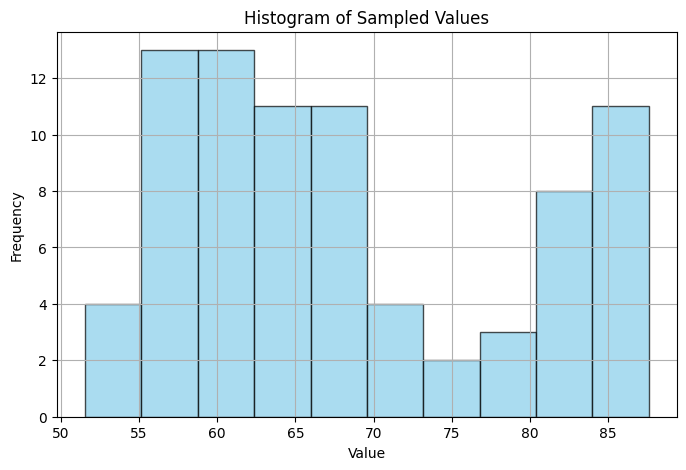

In [144]:
import matplotlib.pyplot as plt
import numpy as np

# Example: sampled_values is your array of values
# sampled_values = np.array([...])  # your actual data here

# Determine number of bins using Freedman-Diaconis rule (or just use default)
def freedman_diaconis_bins(data):
    q75, q25 = np.percentile(data, [75 ,25])
    iqr = q75 - q25
    bin_width = 2 * iqr * len(data) ** (-1/3)
    bins = int((data.max() - data.min()) / bin_width)
    return max(10, bins)  # at least 10 bins

bins = freedman_diaconis_bins(sampled_values)

plt.figure(figsize=(8,5))
plt.hist(sampled_values, bins=bins, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Sampled Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()